In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_workout = pd.read_csv('workout.csv')
df_weather = pd.read_csv('weather.csv')

# Cleaning workout

### Extract Month, Day and Hour from the workouts

#### Calculate start and end hour of workouts

In [3]:
df_workout['Start time'] = pd.to_datetime(df_workout['Start time']).dt.floor('1H')
df_workout['End time'] = (df_workout['Start time'] + df_workout['Duration'].apply(lambda x: np.timedelta64(int(x),'s'))).dt.ceil('1H')

### Calculate rest days

In [4]:
avg_rest_day = 0
for i in range(1, len(df_workout)):
    rest_day = (df_workout.loc[i - 1, 'End time'] - df_workout.loc[i, 'Start time']).days
    df_workout.loc[i,'Rest day'] = rest_day
    avg_rest_day += rest_day
    
avg_rest_day /= (len(df_workout) - 1)
df_workout.loc[0, 'Rest day'] = avg_rest_day
df_workout['Rest day'] = df_workout['Rest day'].apply(lambda x: int(x))

In [5]:
df_workout.head()

,Average speed,Max speed,Distance,Duration,Start time,End time,Rest day
0,26.594017,42.7476,38.649971,5232.0,2018-10-14 14:00:00,2018-10-14 16:00:00,1
1,23.805997,38.8814,38.803776,5868.0,2018-10-12 16:00:00,2018-10-12 18:00:00,2
2,25.046723,41.6592,38.662399,5557.0,2018-10-09 18:00:00,2018-10-09 20:00:00,3
3,25.198437,44.5750,38.700600,5529.0,2018-10-07 17:00:00,2018-10-07 19:00:00,2
4,25.086550,42.8115,38.668129,5549.0,2018-10-06 18:00:00,2018-10-06 20:00:00,1


# Cleaning weather

In [6]:
df_weather = df_weather.drop(['City', 'Date epoch'], axis=1);

In [7]:
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

In [8]:
for i in range(len(df_weather)):
    df_weather.loc[i, 'Date'] = df_weather.loc[i, 'Date'] + np.timedelta64(int(df_weather.loc[i, 'Time']), 'h')

In [9]:
df_weather = df_weather.drop(['Time'], axis=1)

In [10]:
df_weather.head()

,Date,Temperature,Wind speed,Precipitation,Humidity
0,2018-04-15 03:00:00,-5,20,0.0,43
1,2018-04-15 04:00:00,-5,19,0.1,46
2,2018-04-15 05:00:00,-4,19,0.1,50
3,2018-04-15 06:00:00,-4,18,0.2,53
4,2018-04-15 07:00:00,-3,19,0.1,52


# Merging workout and weather data

In [11]:
for i in range(len(df_workout)):
    mask = (df_weather['Date'] >= df_workout.loc[i, 'Start time']) & (df_weather['Date'] <= df_workout.loc[i, 'End time'])
    df_workout.loc[i, 'Temperature'] = df_weather.loc[mask]['Temperature'].mean()
    df_workout.loc[i, 'Wind speed'] = df_weather.loc[mask]['Wind speed'].mean()
    df_workout.loc[i, 'Precipitation'] = df_weather.loc[mask]['Precipitation'].mean()
    df_workout.loc[i, 'Humidity'] = df_weather.loc[mask]['Humidity'].mean()

#### Remove pivot features

In [12]:
df_workout = df_workout.drop(['End time','Max speed', 'Duration','Start time'], axis=1)

In [13]:
df_workout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 7 columns):
Average speed    88 non-null float64
Distance         88 non-null float64
Rest day         88 non-null int64
Temperature      88 non-null float64
Wind speed       88 non-null float64
Precipitation    88 non-null float64
Humidity         88 non-null float64
dtypes: float64(6), int64(1)
memory usage: 4.9 KB


# Analize data

In [24]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.externals import joblib

In [25]:
max_depth = 30
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=max_depth,
                                                          random_state=0))

In [26]:
y = np.array([df_workout['Average speed'], df_workout['Distance']]).T
X = df_workout.drop(['Average speed','Distance'], axis=1).values
print(X.shape, y.shape)

(88, 5) (88, 2)


In [27]:
square_error_sum = np.array([0.0,0.0])

loo = LeaveOneOut()
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = model.fit(X_train, y_train)
    predicted_y = model.predict(X_test)
    square_error_sum += np.square(y_test[0] - predicted_y[0])
mse = [x / X.shape[0] for x in square_error_sum]
print(mse)

[1.2306607761292663, 96.03891046723952]


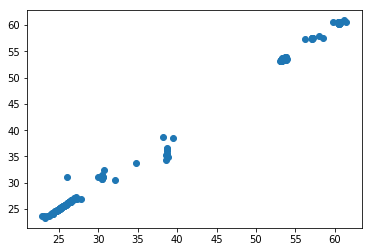

In [30]:
predictions = cross_val_predict(model, df_workout, y, cv=6)
plt.scatter(y, predictions)

In [31]:
scores = cross_val_score(model, df_workout, y, cv=6)
print('Cross-validated scores:', scores)

Cross-validated scores: [0.94393588 0.96444625 0.99814098 0.99083401 0.9970861  0.99047747]


In [32]:
accuracy = metrics.r2_score(y, predictions)
print('Cross-Predicted Accuracy:', accuracy)

Cross-Predicted Accuracy: 0.9809902731434532


In [33]:
joblib.dump(model, 'model.joblib')

['model.joblib']